In [1]:
!pip install -U segmentation-models==1.0.1
import segmentation_models as smp
from segmentation_models import Linknet
from segmentation_models import get_preprocessing
from segmentation_models.losses import dice_loss
from segmentation_models.metrics import iou_score

     |████████████████████████████████| 50 kB 6.5 MB/s 
Segmentation Models: using `keras` framework.


In [2]:
import os
import torch
import matplotlib.pyplot as plt

from pprint import pprint
from torch.utils.data import DataLoader

In [3]:
import shutil

shutil.unpack_archive("/content/drive/MyDrive/CelebAMask.tar.gz", "/content/")

In [4]:
import numpy as np
from PIL import Image


def get_images(images_dir, masks_dir, cl):
  imgs = []
  masks = []
  loader = []
  masks_ids = os.listdir(masks_dir)
  for file_ in os.listdir(images_dir):
    image = Image.open(images_dir + file_)
    image = np.array(image).astype('float32')

    mask_name = file_.split('.')[0].zfill(5) + '_' + cl + '.png'
    if mask_name in masks_ids:
      mask = Image.open(masks_dir + mask_name)
      mask = (np.expand_dims(np.array(mask)[:,:,0], -1) / 255).astype('float32')
    else:
      mask = (np.zeros((128, 128, 1)))

    imgs.append(image)
    masks.append(mask)
    loader.append([image, mask])
  return imgs, masks, loader

In [5]:
import os

CLASS = 'hair'

X_train, y_train, train_data = get_images('CelebAMask/train_img/', 'CelebAMask/train_mask/', CLASS)
X_test, y_test, test_data = get_images('CelebAMask/test_img/', 'CelebAMask/test_mask/', CLASS)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

n_cpu = os.cpu_count()

Train size: 3750
Test size: 1250


In [ ]:
train_data[0][1].shape

(128, 128, 1)

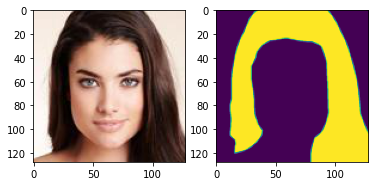

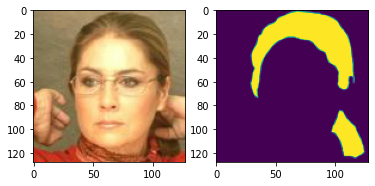

In [6]:

plt.subplot(1,2,1)
plt.imshow(X_train[0].astype('uint8'))
plt.subplot(1,2,2)
plt.imshow(np.array(y_train[0])[:,:,0])
plt.show()


plt.subplot(1,2,1)
plt.imshow(X_test[0].astype('uint8'))
plt.subplot(1,2,2)
plt.imshow(np.array(y_test[0])[:,:,0])
plt.show()

In [7]:
from tensorflow.keras.utils import Sequence

class Dataloder(Sequence):

  def __init__(self, dataset, batch_size=1, shuffle=False):
      self.dataset = dataset
      self.batch_size = batch_size
      self.shuffle = shuffle
      self.indexes = np.arange(len(dataset))

      self.on_epoch_end()

  def __getitem__(self, i):
      
      # collect batch data
      start = i * self.batch_size
      stop = (i + 1) * self.batch_size
      data = []
      for j in range(start, stop):
          data.append(self.dataset[j])
      
      # transpose list of lists
      batch = [np.stack(samples, axis=0) for samples in zip(*data)]
      
      # newer version of tf/keras want batch to be in tuple rather than list
      return tuple(batch)

  def __len__(self):
    """Denotes the number of batches per epoch"""
    return len(self.indexes) // self.batch_size

  def on_epoch_end(self):
    """Callback function to shuffle indexes each epoch"""
    if self.shuffle:
        self.indexes = np.random.permutation(self.indexes)


train_loader = Dataloder(train_data, 16, True)
test_loader = Dataloder(test_data, 16, False)

In [8]:
import segmentation_models as sm

sm.set_framework('tf.keras')

BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)


# preprocess input
train_loader = preprocess_input(train_loader)
test_loader = preprocess_input(test_loader)

# define model
model = Linknet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=dice_loss, metrics=[iou_score])

# fit model
model.fit(
    train_loader,
    batch_size=16,
    epochs=5,
    validation_data=test_loader,
)

85532672/85521592 [==============================] - 1s 0us/step
Epoch 1/5
234/234 [==============================] - 998s 4s/step - loss: 0.1751 - iou_score: 0.7135 - val_loss: 0.1901 - val_iou_score: 0.6818
Epoch 2/5
234/234 [==============================] - 920s 4s/step - loss: 0.1026 - iou_score: 0.8148 - val_loss: 0.1048 - val_iou_score: 0.8111
Epoch 3/5
234/234 [==============================] - 875s 4s/step - loss: 0.0937 - iou_score: 0.8293 - val_loss: 0.1084 - val_iou_score: 0.8053
Epoch 4/5
234/234 [==============================] - 884s 4s/step - loss: 0.0916 - iou_score: 0.8330 - val_loss: 0.1310 - val_iou_score: 0.7696
Epoch 5/5
234/234 [==============================] - 1071s 5s/step - loss: 0.0826 - iou_score: 0.8480 - val_loss: 0.0798 - val_iou_score: 0.8526


In [9]:
model.save('model.pth')

INFO:tensorflow:Assets written to: model.pth/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


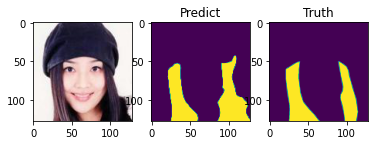

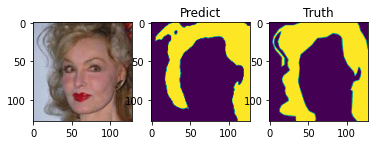

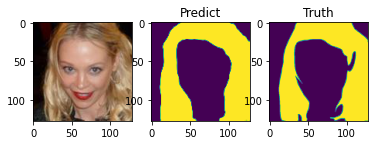

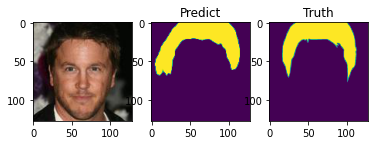

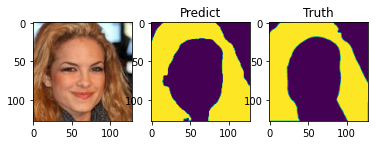

In [23]:
for i in range(5):
  n = np.random.choice(len(test_data))
  
  image, gt_mask = test_data[n]
  
  pr_mask = model.predict(np.expand_dims(image, axis=0))

      
  plt.subplot(1,3,1)
  plt.imshow(image.astype('uint8')) # for visualization we have to transpose back to HWC
  plt.subplot(1,3,2)
  plt.imshow(pr_mask[0,:,:,0])  # for visualization we have to remove 3rd dimension of mask
  plt.title("Predict")
  plt.subplot(1,3,3)
  plt.imshow(gt_mask[:,:,0])  # for visualization we have to remove 3rd dimension of mask
  plt.title("Truth")
  plt.show()

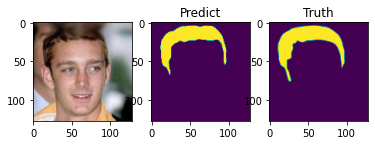

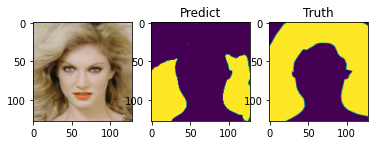

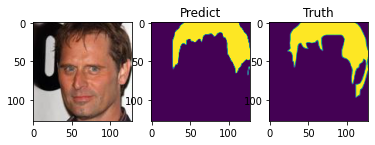

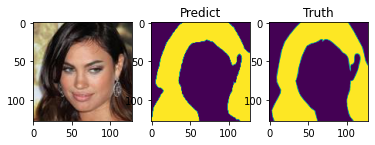

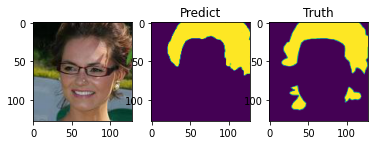

In [25]:
for i in range(5):
  n = np.random.choice(len(test_data))
  
  image, gt_mask = test_data[n]
  
  pr_mask = model.predict(np.expand_dims(image, axis=0))

      
  plt.subplot(1,3,1)
  plt.imshow(image.astype('uint8')) # for visualization we have to transpose back to HWC
  plt.subplot(1,3,2)
  plt.imshow(pr_mask[0,:,:,0])  # for visualization we have to remove 3rd dimension of mask
  plt.title("Predict")
  plt.subplot(1,3,3)
  plt.imshow(gt_mask[:,:,0])  # for visualization we have to remove 3rd dimension of mask
  plt.title("Truth")
  plt.show()